In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from termcolor import cprint
HERE = os.getcwd()
# HERE = 'c:\\Users\\harry\\Documents\\code_ws\\pb_ws\\coop_assembly\\src\\coop_assembly\\planning\\'
pyplanner_path = os.path.abspath(os.path.join(HERE, '..', '..', '..', 'external', 'pyplanners'))
sys.path.extend([
    os.path.abspath(os.path.join(HERE, '..', '..', '..', 'external', 'pddlstream')),
    pyplanner_path,
])
os.environ['PYPLANNERS_PATH'] = pyplanner_path

import pddlstream
cprint("Using pddlstream from {}".format(pddlstream.__file__), 'yellow')
import strips # pyplanners
cprint("Using strips from {}".format(strips.__file__), 'yellow')

Using pddlstream from C:\Users\harry\Documents\code_ws\pb_ws\coop_assembly\external\pddlstream\pddlstream\__init__.py
Using strips from C:\Users\harry\Documents\code_ws\pb_ws\coop_assembly\external\pyplanners\strips\__init__.py


In [3]:
import numpy as np
np.set_printoptions(precision=3)

## Load shapes

In [4]:
TRANS_TOL = 0.001
ROT_TOL = np.inf

In [64]:
from collections import namedtuple, defaultdict

SimpleBarStructure = namedtuple('SimpleBarStructure', ['node_points', 'elements', 'grounded_nodes'])

In [65]:
from coop_assembly.planning.stiffness import solid_cir_crosssec, wood_material
from pyconmech.frame_analysis import GravityLoad, Node, Element, Support, Material, \
    CrossSec, Material, Joint, Model, LoadCase

def create_conmech_model(simple_bar_struct, model_name='temp', presample_scaffolds=True, save_model=False):
    # ! meter-based unit
    unit = "meter"

    # TODO break the lines into pieces according to the connectors
    # axis points should all be unique
    cm_nodes = []
    for i, node in enumerate(simple_bar_struct.node_points):
        # Node(self, point, node_ind, is_grounded):
        # ! is_grounded is used to mark grounded nodes for construction purpose
        # structural supports are specified using the Support entries
        cm_nodes.append(Node(node, i, False))

    # Add elements
    fem_element_from_bar_id = defaultdict(set)
    cm_elements = []
    element_tags = set()
    for i, node_inds in enumerate(simple_bar_struct.elements):
        element_tag = 'bar'
        cm_elements.append(Element(node_inds, i, elem_tag=element_tag, bending_stiff=True))
        element_tags.add(element_tag)
        fem_element_from_bar_id[i].add(i)
    
    # Add supports
    cm_supports = []
    for node_ind in simple_bar_struct.grounded_nodes:
        cm_supports.append(Support([1,1,1,1,1,1], node_ind))
    
    if presample_scaffolds:
        # TODO might restrict to a subset of nodes to add scaffolds
        ground_z = min([node.point[2] for node in cm_nodes])
        scaffold_tags = set()
        projected_nodes = []
        for i, up_node in enumerate(cm_nodes):
            if up_node.is_grounded or abs(up_node.point[2]-ground_z)<1e-12:
                continue
            new_node_id = len(projected_nodes)+len(cm_nodes)
            projected_node = Node([up_node.point[0], up_node.point[1], ground_z], new_node_id, True)
            projected_nodes.append(projected_node)

            new_node_inds = (up_node.node_ind, projected_node.node_ind)
            scaffold_tag = 'scaffold' #.format(projected_node.node_ind)
            new_element_id = len(cm_elements)
            cm_elements.append(Element(new_node_inds, new_element_id, elem_tag=scaffold_tag, bending_stiff=True))

            # TODO lump the scaffold element to bar_id? new dict?
            # fem_element_from_bar_id[new_element_id].add(new_element_id)
            scaffold_tags.add(scaffold_tag)

            # TODO should only chosen one contact point as fixiety
            cm_supports.append(Support([1 for _ in range(6)], projected_node.node_ind))
        cm_nodes.extend(projected_nodes)

    # TODO Add rotational stiffness later
#     ? Joint(self, c_conditions, elem_tags):
#     node_c_conditions = [None, None, None] + [ROTATIONAL_STIFFNESS for _ in range(3)]
    # joint = Joint(node_c_conditions+node_c_conditions, list(bar_tags | connector_tags))
    joints = []

    # TODO different material property and cross secs on Element and Connectors
    r = 0.01 # in meter
    crosssecs = [solid_cir_crosssec(r, elem_tags=list(element_tags))]
    materials = [wood_material(list(element_tags))]
    if presample_scaffolds:
        crosssecs.append(solid_cir_crosssec(r, elem_tags=list(scaffold_tags)))
        materials.append(wood_material(list(scaffold_tags)))

    model = Model(cm_nodes, cm_elements, cm_supports, joints, materials, crosssecs, unit=unit, model_name=model_name)
    if save_model:
        model_path = os.path.join(HERE, 'simple_structures', model_name + '_conmech_model.json')
        model_data = model.to_data()
        with open(model_path, 'w') as f:
            json.dump(model_data, f, indent=None)
        cprint('Conmech model saved to: {}'.format(model_path), 'green')
    return model, fem_element_from_bar_id

In [66]:
from pyconmech.frame_analysis import StiffnessChecker

def create_stiffness_checker_simple(simple_bar_struct, verbose=False, trans_tol=TRANS_TOL, **kwargs):
    # * convert ball structure to a conmech model
    model, fem_element_from_bar_id = create_conmech_model(simple_bar_struct, **kwargs)
    checker = StiffnessChecker(model, verbose=verbose, checker_engine="numpy")
    checker.set_loads(LoadCase(gravity_load=GravityLoad([0,0,-1.0])))
    checker.set_nodal_displacement_tol(trans_tol=trans_tol, rot_tol=ROT_TOL)
    return checker, fem_element_from_bar_id

In [67]:
from coop_assembly.planning.stiffness import Deformation, Displacement, Reaction

def evaluate_stiffness(simple_bar_struct, elements, checker=None, fem_element_from_bar_id=None, \
                       trans_tol=TRANS_TOL, verbose=True):
    # TODO: check each connected component individually
    if not elements:
        return Deformation(True, {}, {}, {})

    if checker is None or fem_element_from_bar_id is None:
        checker, fem_element_from_bar_id = create_stiffness_checker_simple(simple_bar_struct, 
                                                                           trans_tol=trans_tol, verbose=verbose)
    exist_element_ids = set()
    for elem in elements:
        if elem in fem_element_from_bar_id and len(fem_element_from_bar_id[elem]) > 0:
            # bar
            exist_element_ids.update(fem_element_from_bar_id[elem])
        else:
            # in the case of scaffolding elements
            exist_element_ids.add(elem)
#     print('existing elem: ', exist_element_ids)
    
    is_stiff = checker.solve(exist_element_ids=list(exist_element_ids), if_cond_num=True)
    if not checker.has_stored_result():
        return Deformation(False, {}, {}, {})

    #print("has stored results: {0}".format(checker.has_stored_result()))
    success, nodal_displacement, fixities_reaction, element_reaction = checker.get_solved_results()
    assert is_stiff == success, "full structure not stiff!"
    assert success or checker.get_compliance() > 0.0, 'success {} | compliance {}'.format(success, checker.get_compliance())
    displacements = {i: Displacement(*d) for i, d in nodal_displacement.items()}
    fixities = {i: Reaction(*d) for i, d in fixities_reaction.items()}
    reactions = {i: (Reaction(*d[0]), Reaction(*d[1])) for i, d in element_reaction.items()}

    #print("nodal displacement (m/rad):\n{0}".format(nodal_displacement)) # nodes x 7
    #print("fixities reaction (kN, kN-m):\n{0}".format(fixities_reaction)) # ground x 7
    #print("element reaction (kN, kN-m):\n{0}".format(element_reaction)) # elements x 13
    trans_tol, rot_tol = checker.get_nodal_deformation_tol()
    max_trans, max_rot, max_trans_vid, max_rot_vid = checker.get_max_nodal_deformation()
    # The inverse of stiffness is flexibility or compliance

    translation = np.max(np.linalg.norm([d[:3] for d in displacements.values()], ord=2, axis=1))
    rotation = np.max(np.linalg.norm([d[3:] for d in displacements.values()], ord=2, axis=1))
    is_stiff &= (translation <= trans_tol) and (rotation <= rot_tol)

    if verbose:
        print('Stiff: {} | Compliance: {:.5f}'.format(is_stiff, checker.get_compliance()))
        print('Max translation deformation: {0:.5f} / {1:.5} = {2:.5}, at node #{3}'.format(
            max_trans, trans_tol, max_trans / trans_tol, max_trans_vid))
        # print('Max rotation deformation: {0:.5f} / {1:.5} = {2:.5}, at node #{3}'.format(
        #     max_rot, rot_tol, max_rot / rot_tol, max_rot_vid))

    return Deformation(is_stiff, displacements, fixities, reactions)

def test_stiffness(bar_struct, elements, **kwargs):
    return evaluate_stiffness(bar_struct, elements, **kwargs).success

In [140]:
def get_midpoint(simple_bar_struct, element):
    return np.average([simple_bar_struct.node_points[i] for i in simple_bar_struct.elements[element]], axis=0)

def compute_z_distance(simple_bar_struct, element):
    # Distance to a ground plane
    # Opposing gravitational force
    return get_midpoint(simple_bar_struct, element)[2]

## test checker

In [165]:
num_seg = 6
x_len = num_seg
y_len = 1.0

node_points = [[x, 0, x * y_len/(num_seg/2)] for x in range(int(num_seg/2))] + \
              [[x, 0, y_len - (x-num_seg/2) * y_len/(num_seg/2)] for x in range(int(num_seg/2), num_seg+1)]
elements = [(i, i+1) for i in range(num_seg)]
grounded_nodes = [0, len(node_points)-1]

In [69]:
simple_bar_struct = SimpleBarStructure(node_points, elements, grounded_nodes)
all_elements = set(range(len(elements)))

In [141]:
compute_z_distance(simple_bar_struct, 0)

0.16666666666666666

In [70]:
elements

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

In [71]:
node_points

[[0, 0, 0.0],
 [1, 0, 0.3333333333333333],
 [2, 0, 0.6666666666666666],
 [3, 0, 1.0],
 [4, 0, 0.6666666666666667],
 [5, 0, 0.33333333333333337],
 [6, 0, 0.0]]

In [72]:
grounded_nodes

[0, 6]

In [73]:
trans_tol = 0.01

In [74]:
test_stiffness(simple_bar_struct, [0,1,2], trans_tol=trans_tol)

Stiff: False | Compliance: 0.00031
Max translation deformation: 0.27105 / 0.01 = 27.105, at node #3


False

In [75]:
test_stiffness(simple_bar_struct, [0,1,2,7], trans_tol=trans_tol)

Stiff: True | Compliance: 0.00000
Max translation deformation: 0.00388 / 0.01 = 0.38834, at node #3


True

In [76]:
test_stiffness(simple_bar_struct, all_elements, trans_tol=trans_tol)

Stiff: True | Compliance: 0.00002
Max translation deformation: 0.00448 / 0.01 = 0.44818, at node #2


True

## Check scaffolds work with conmech

In [166]:
import pybullet_planning as pp

connect_pb = True
viewer = True
if connect_pb:
    pp.connect(use_gui=viewer)
    pp.create_plane(color=pp.WHITE)
    pp.draw_pose(pp.unit_pose())

In [167]:
from stiffness import draw_conmech_model

checker, fem_element_from_bar_id = create_stiffness_checker_simple(simple_bar_struct, trans_tol=trans_tol, presample_scaffolds=True)
            
if connect_pb:
    draw_conmech_model(checker.model, fem_element_from_bar_id, elements=None);

In [82]:
fem_element_from_bar_id

defaultdict(set, {0: {0}, 1: {1}, 2: {2}, 3: {3}, 4: {4}, 5: {5}})

In [155]:
pp.disconnect()

In [83]:
checker.model.elements

[Element(#0(bar),(0, 1),Bend:True),
 Element(#1(bar),(1, 2),Bend:True),
 Element(#2(bar),(2, 3),Bend:True),
 Element(#3(bar),(3, 4),Bend:True),
 Element(#4(bar),(4, 5),Bend:True),
 Element(#5(bar),(5, 6),Bend:True),
 Element(#6(scaffold),(1, 7),Bend:True),
 Element(#7(scaffold),(2, 8),Bend:True),
 Element(#8(scaffold),(3, 9),Bend:True),
 Element(#9(scaffold),(4, 10),Bend:True),
 Element(#10(scaffold),(5, 11),Bend:True)]

In [169]:
pp.remove_all_debug()

### Before adding the scaffold element

In [175]:
partial_elements = [0,1,2]

test_stiffness(simple_bar_struct, partial_elements, checker=checker,
    fem_element_from_bar_id=fem_element_from_bar_id, verbose=True, trans_tol=trans_tol)

if connect_pb:
    draw_conmech_model(checker.model, fem_element_from_bar_id, elements=partial_elements);

Stiff: False | Compliance: 0.00031
Max translation deformation: 0.27105 / 0.01 = 27.105, at node #3


In [176]:
pp.remove_all_debug()

### After adding the scaffold element

In [177]:
new_partial_elements = partial_elements + [8]
print(new_partial_elements)

test_stiffness(simple_bar_struct, new_partial_elements, checker=checker,
    fem_element_from_bar_id=fem_element_from_bar_id, verbose=True, trans_tol=trans_tol)

if connect_pb:
    draw_conmech_model(checker.model, fem_element_from_bar_id, elements=new_partial_elements);

[0, 1, 2, 8]
Stiff: False | Compliance: 0.00031
Max translation deformation: 0.27105 / 0.01 = 27.105, at node #3


In [172]:
pp.remove_all_debug()

## Unconnected

In [87]:
partial_elements = [0,1,3]

test_stiffness(simple_bar_struct, partial_elements, checker=checker,
    fem_element_from_bar_id=fem_element_from_bar_id, verbose=True, trans_tol=trans_tol)

# if connect_pb:
#     draw_conmech_model(checker.model, fem_element_from_bar_id, elements=partial_elements);

False

In [88]:
partial_elements = [1,3]

test_stiffness(simple_bar_struct, partial_elements, checker=checker,
    fem_element_from_bar_id=fem_element_from_bar_id, verbose=True, trans_tol=trans_tol)

# if connect_pb:
#     draw_conmech_model(checker.model, fem_element_from_bar_id, elements=partial_elements);

False

## Define stream functions

In [89]:
from coop_assembly.planning.utils import compute_z_distance, check_connected, Command
from coop_assembly.planning.stiffness import test_stiffness

def get_wild_remove_element_gen_fn(simple_bar_struct, element_from_index, grounded_elements, debug=False, use_fluent=True, \
    connectivity=True, stiffness=True, checker_info=(None,None), verbose=False):
    def wild_gen_fn(robot_name, element, fluents=[]):
        next_printed = set()
        for fact in fluents:
            if fact[0] == 'assembled':
                #if fact[1] != element:
                next_printed.add(fact[1])
            else:
                raise NotImplementedError(fact[0])

        assert element in next_printed
        next_printed = next_printed - {element}
        if verbose:
            print('---')
            print('Remove E{} - fluent printed ({}): {}'.format(element, len(next_printed), sorted(next_printed)))

        # # * partial ordering
        # if ordering and (outgoing_from_element[element] & next_printed):
        #     # outgoing elements must be removed BEFORE element
        #     cprint('Ordering fails.', 'red')
        #     return

#         # * connectivity
#         if connectivity and not check_connected(connectors, grounded_elements, next_printed):
#             if verbose: cprint('Connectivity fails.', 'red')
#             return

        if stiffness and not test_stiffness(bar_struct, next_printed, checker=checker_info[0],
            fem_element_from_bar_id=checker_info[1], verbose=verbose):
            if verbose: cprint('Stiffness fails.', 'red')
            return

        if debug:
            num_outputs = 2 if use_fluent else 3
            outputs = [num_outputs*(None,)]
            yield outputs # For debugging
            return
        
        command = Command([])
        grasp = None
        outputs = [(command, grasp)]
        yield outputs
    # end wild_gen_fn
    return wild_gen_fn

In [90]:
def get_wild_add_element_gen_fn(simple_bar_struct, debug=False,
    use_fluent=True, connectivity=True, stiffness=True, allow_scaffolds=False, checker_info=(None,None), 
    verbose=False):
    all_elements = set(range(len(simple_bar_struct.elements)))
    def wild_gen_fn(robot_name, element, fluents=[]):
        next_printed = set()
        scaffold_printed = set()
        for fact in fluents:
            if fact[0] == 'assembled':
                next_printed.add(fact[1])
            else:
                raise NotImplementedError(fact[0])                

        assert element not in next_printed
        next_printed = next_printed | {element}
        if verbose:
            print('---')
            print('Add E{} - fluent printed ({}): {}'.format(element, len(next_printed), sorted(next_printed)))

        # # * partial ordering
        # if ordering and (outgoing_from_element[element] & next_printed):
        #     # outgoing elements must be removed BEFORE element
        #     cprint('Ordering fails.', 'red')
        #     return

        # * connectivity, only for original structure for now
#         if connectivity and not check_connected(connectors, grounded_elements, next_printed & all_elements):
#             if verbose: cprint('Connectivity fails.', 'red')
#             return

        if stiffness and not test_stiffness(simple_bar_struct, next_printed, checker=checker_info[0],
            fem_element_from_bar_id=checker_info[1], verbose=verbose):
            if verbose: cprint('Stiffness fails.', 'red')
            return

        if debug:
            num_outputs = 2 if use_fluent else 3
            outputs = [num_outputs*(None,)]
            yield outputs # For debugging
            return
        
        command = Command([])
        grasp = None
        outputs = [(command, grasp)]
        yield outputs
    # end wild_gen_fn
    return wild_gen_fn

In [96]:
def get_wild_add_scaffold_element_gen_fn(simple_bar_struct, bar_id_from_scaffolds, debug=False,
    use_fluent=True, connectivity=True, stiffness=True, checker_info=(None,None), verbose=False):
    def wild_gen_fn(robot_name, scaffold_element, fluents=[]):
        next_printed = set()
        for fact in fluents:
            if fact[0] == 'assembled':
                next_printed.add(fact[1])
            else:
                raise NotImplementedError(fact[0])

        if verbose:
            print('---')
            print('Add Scaffold E{} - fluent printed ({}): {}'.format(scaffold_element, len(next_printed), sorted(next_printed)))

        # # * partial ordering
        # if ordering and (outgoing_from_element[element] & next_printed):
        #     # outgoing elements must be removed BEFORE element
        #     cprint('Ordering fails.', 'red')
        #     return

        # * connectivity
        if connectivity and not (bar_id_from_scaffolds[scaffold_element] & next_printed):
            if verbose: cprint('Scaffold connectivity fails.', 'red')
            return

        next_printed = next_printed | {scaffold_element}
        if stiffness and not test_stiffness(simple_bar_struct, next_printed, checker=checker_info[0],
            fem_element_from_bar_id=checker_info[1], verbose=verbose):
            if verbose: cprint('Scaffold stiffness fails.', 'red')
            return

        if debug:
            num_outputs = 2 if use_fluent else 3
            outputs = [num_outputs*(None,)]
            yield outputs # For debugging
            return
        
        command = Command([])
        grasp = None
        outputs = [(command, grasp)]
        yield outputs
    # end wild_gen_fn
    return wild_gen_fn

## Validators

In [103]:
def compute_plan_deformation(simple_bar_struct, plan, verbose=False, trans_tol=TRANS_TOL, checker=None,
    fem_element_from_bar_id=None):
    if checker is None or fem_element_from_bar_id is None:
        checker, fem_element_from_bar_id = create_stiffness_checker_simple(simple_bar_struct, verbose=False, \
                                                                           trans_tol=trans_tol)
    trans_tol, rot_tol = checker.get_nodal_deformation_tol()
    if plan is None:
        return trans_tol, rot_tol

    printed = []
    translations = []
    rotations = []
    for i, element in enumerate(plan):
        if verbose:
            cprint('{}) : bar#{}'.format(i, element), 'yellow')
        printed.append(element)
        deformation = evaluate_stiffness(simple_bar_struct, printed,
                                         checker=checker, fem_element_from_bar_id=fem_element_from_bar_id, verbose=verbose)
        trans, rot, _, _ = checker.get_max_nodal_deformation()
        translations.append([bool(deformation.success), trans])
        rotations.append(rot)
    # TODO: could return full history
    return translations

## Construct PDDL problem

In [156]:
printed=set()
removed=set()
debug = False

# constraint
stiffness = True
forward = True
allow_scaffold = True
costs = False
verbose = False

trans_tol = 0.01

In [157]:
from stiffness import conmech_model_from_bar_structure, create_stiffness_checker, evaluate_stiffness, draw_conmech_model

checker, fem_element_from_bar_id = create_stiffness_checker_simple(simple_bar_struct, 
                                                                   presample_scaffolds=True, trans_tol=trans_tol)
            
# if connect_pb:
#     draw_conmech_model(checker.model, fem_element_from_bar_id, elements=None);

from collections import defaultdict

elem_ind_from_elem_tag = checker._sc_ins.get_elem_ind_from_elem_tag()
scaffold_elements = elem_ind_from_elem_tag['scaffold']

cm_nodes_from_bar_id = defaultdict(set)
for bar_id, fem_es in fem_element_from_bar_id.items():
    for fem_e_id in fem_es:
        fem_element = checker.model.elements[fem_e_id]
        cm_nodes_from_bar_id[bar_id].update(fem_element.end_node_inds)
        
bar_id_from_scaffolds = defaultdict(set)
for se_id in scaffold_elements:
    se_element = checker.model.elements[se_id]
    for bar_id, cm_node_ids in cm_nodes_from_bar_id.items():
        for cm_node_id in list(cm_node_ids):
            if cm_node_id in se_element.end_node_inds:
                if bar_id != -1:
                    bar_id_from_scaffolds[se_id].add(bar_id)

all_scaffolds = set(bar_id_from_scaffolds)

In [158]:
cm_nodes_from_bar_id

defaultdict(set,
            {0: {0, 1}, 1: {1, 2}, 2: {2, 3}, 3: {3, 4}, 4: {4, 5}, 5: {5, 6}})

In [159]:
from pddlstream.utils import read
from pddlstream.language.stream import StreamInfo, PartialInputs, WildOutput, DEBUG
from pddlstream.language.constants import And, PDDLProblem, Equal, print_plan

formu = 'forward' if forward else 'backward'
if allow_scaffold:
    formu += '_scaffold'
domain_pddl = read(os.path.join(HERE, 'pddl/stiffness/domain_{}.pddl'.format(formu)))
stream_pddl = read(os.path.join(HERE, 'pddl/stiffness/stream_{}.pddl'.format(formu)))

init = []
init.extend([
    ('Robot', 'r0'),
])

remaining = set(range(len(simple_bar_struct.elements))) - removed - printed
for e in remaining:
    init.extend([
        ('Element', e),
        ('Removed', e) if forward else ('Assembled', e),
    ])
if allow_scaffold:
    for e in all_scaffolds:
        init.extend([
            ('ScaffoldElement', e),
            ('Removed', e),
        ])

constant_map = {}
checker_info = (checker, fem_element_from_bar_id)
if forward:
    stream_map = {
        'sample-add': get_wild_add_element_gen_fn(simple_bar_struct,
            debug=debug, stiffness=stiffness, checker_info=checker_info, verbose=verbose)
    }
else:
    stream_map = {
        'sample-remove': get_wild_remove_element_gen_fn(simple_bar_struct,
            debug=debug, stiffness=stiffness, checker_info=checker_info, verbose=verbose)
    }

if allow_scaffold:
    stream_map['sample-add-scaffold'] = get_wild_add_scaffold_element_gen_fn(simple_bar_struct, bar_id_from_scaffolds, 
        debug=False, use_fluent=True, connectivity=True, stiffness=True, checker_info=checker_info, verbose=verbose)

if debug:
    stream_map = DEBUG

goal_literals = []
if forward:
    goal_literals.extend(('Assembled', e) for e in remaining)
else:
    goal_literals.extend(('Removed', e) for e in remaining)

# TODO require scaffolds to be removed at the end    
# if allow_scaffold:
#     goal_literals.extend(('Removed', e) for e in all_scaffolds)

goal = And(*goal_literals)

pddlstream_problem = PDDLProblem(domain_pddl, constant_map, stream_pddl, stream_map, init, goal)

print('Init:', pddlstream_problem.init)
print('Goal:', pddlstream_problem.goal)

Init: [('Robot', 'r0'), ('Element', 0), ('Removed', 0), ('Element', 1), ('Removed', 1), ('Element', 2), ('Removed', 2), ('Element', 3), ('Removed', 3), ('Element', 4), ('Removed', 4), ('Element', 5), ('Removed', 5), ('ScaffoldElement', 6), ('Removed', 6), ('ScaffoldElement', 7), ('Removed', 7), ('ScaffoldElement', 8), ('Removed', 8), ('ScaffoldElement', 9), ('Removed', 9), ('ScaffoldElement', 10), ('Removed', 10)]
Goal: ('and', ('Assembled', 0), ('Assembled', 1), ('Assembled', 2), ('Assembled', 3), ('Assembled', 4), ('Assembled', 5))


## Solve

In [160]:
from pddlstream.algorithms.downward import set_cost_scale, parse_action
from pddlstream.algorithms.incremental import solve_incremental
from pddlstream.utils import INF

set_cost_scale(1)
success_cost = 0 if costs else INF
discrete_planner = {
    'search': 'eager', # eager | lazy
    # lazy might be faster but the solution quality might be low
    'evaluator': 'greedy',
    'heuristic': 'goal', # goal | add | ff
    #'heuristic': ['ff', get_bias_fn(element_from_index)],
    'successors': 'all', # all | random
    # tiebreaker
    #'successors': get_order_fn(element_from_index),
    # ? ordering scaffolds can come here
    # TODO: confirm that this is working correctly
}
solution = solve_incremental(pddlstream_problem, max_time=600, planner=discrete_planner,
                                success_cost=success_cost, unit_costs=not costs,
                                max_planner_time=300, debug=debug, verbose=True)

Calls: 0 | Successes: 0 | Results: 0 | Counts: Counter()
Iteration: 1 | Complexity: 0 | Calls: 0 | Evaluations: 23 | Solved: False | Cost: inf | Time: 0.001
Summary: {complexity: 0, cost: 9.0, evaluations: 23, iterations: 1, length: 9, run_time: 0.10094332695007324, solutions: 1, solved: True, timeout: False}


In [161]:
from pddlstream.language.constants import print_plan, is_plan

plan, _, facts = solution
# print('-'*10)
print_plan(plan)
assert is_plan(plan)

if not forward:
    actions = [action for action in reversed(plan) if action.name == 'remove_element']
else:
    actions = [action for action in plan if action.name == 'add_element' or action.name == 'add_scaffold_element']
element_sequence = [ac.args[2] for ac in actions]

 1) add_element r0 c[] 0 None
 2) add_element r0 c[] 5 None
 3) add_scaffold_element r0 c[] 6 None
 4) add_element r0 c[] 1 None
 5) add_scaffold_element r0 c[] 7 None
 6) add_element r0 c[] 2 None
 7) add_scaffold_element r0 c[] 8 None
 8) add_element r0 c[] 3 None
 9) add_element r0 c[] 4 None


In [162]:
element_sequence

[0, 5, 6, 1, 7, 2, 8, 3, 4]

In [163]:
# from coop_assembly.planning.validator import compute_plan_deformation

translations = compute_plan_deformation(simple_bar_struct, element_sequence, \
                                        checker=checker, fem_element_from_bar_id=fem_element_from_bar_id)

Text(0.5, 1.0, 'Squence')

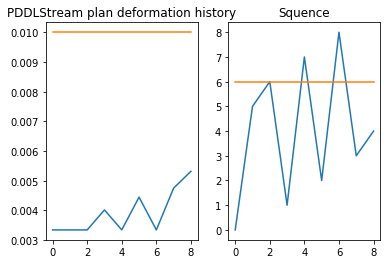

In [164]:
import matplotlib.pyplot as plt
from coop_assembly.planning.stiffness import TRANS_TOL

plt.figure(1)
plt.subplot(121)
plt.plot([t[1] for t in translations])
plt.plot([trans_tol for _ in translations])
plt.title('PDDLStream plan deformation history')

plt.subplot(122)
plt.plot(element_sequence)
num_bars = len(simple_bar_struct.elements)
plt.plot([num_bars for _ in element_sequence])
plt.title('Squence')

### Progression search

In [147]:
import time
import random
import heapq
from pybullet_planning import elapsed_time, randomize

def plan_stiffness(bar_struct, elements, initial_position=None, checker=None, fem_element_from_bar_id=None, trans_tol=TRANS_TOL,\
        stiffness=True, heuristic='z', max_time=INF, max_backtrack=0, verbose=False):
    """use the progression algorithm to plan a stiff sequence
    """
    start_time = time.time()
    # TODO the bar index gives the algorithm hints, try other starting point
    # TODO chosen bars
    if stiffness and (checker is None or fem_element_from_bar_id is None):
        checker, fem_element_from_bar_id = create_stiffness_checker_simple(bar_struct, trans_tol=trans_tol)

    # all_elements = frozenset(element_from_index)
    remaining_elements = frozenset(elements)
    min_remaining = len(remaining_elements)
    max_bt = stiffness_failures = 0
    queue = [(None, frozenset(), [])]
    while queue and (elapsed_time(start_time) < max_time):
        # TODO pop position and try distance heuristic
        _, printed, sequence = heapq.heappop(queue)
        num_remaining = len(remaining_elements) - len(printed)
        backtrack = num_remaining - min_remaining
        max_bt = max(max_bt, backtrack)
        if max_backtrack < backtrack:
            break # continue

        # * check constraints
#         if not check_connected(connectors, grounded_elements, printed):
#             continue
        if stiffness and not test_stiffness(bar_struct, printed, checker=checker, fem_element_from_bar_id=fem_element_from_bar_id, verbose=verbose):
            stiffness_failures += 1
            continue

        if printed == remaining_elements:
            # * Done!
            #from extrusion.visualization import draw_ordered
            # distance = compute_sequence_distance(node_points, sequence, start=initial_position, end=initial_position)
            cprint('Plan-stiffness success! Elements: {}, max BT: {}, stiffness failure: {}, Time: {:.3f}sec'.format(len(sequence), max_bt, stiffness_failures, elapsed_time(start_time))) #Distance: {:.3f}m,
            #local_search(extrusion_path, element_from_id, node_points, ground_nodes, checker, sequence,
            #             initial_position=initial_position, stiffness=stiffness, max_time=INF)
            #draw_ordered(sequence, node_points)
            #wait_for_user()
            return sequence

        # * add successors
        for element in randomize(remaining_elements - printed):
            new_printed = printed | {element}
            new_sequence = sequence + [element]
            num_remaining = len(remaining_elements) - len(new_printed)
            min_remaining = min(min_remaining, num_remaining)
            # Don't count edge length
            # distance = get_distance(position, node_points[node1]) if position is not None else None
            # distance = compute_sequence_distance(node_points, new_sequence)
            if heuristic == 'none':
                bias = None
            elif heuristic == 'random':
                bias = random.random()
            elif heuristic == 'z':
                bias = compute_z_distance(simple_bar_struct, element)
            # elif heuristic == 'distance':
            #     bias = distance
            else:
                raise ValueError(heuristic)
            #bias = heuristic_fn(printed, element, conf=None) # TODO: experiment with other biases
            priority = (num_remaining, bias, random.random())
            heapq.heappush(queue, (priority, new_printed, new_sequence))

    cprint('Failed to find stiffness plan under tol {}! Elements: {}, Min remaining {}, Time: {:.3f}sec'.format(
        trans_tol, len(remaining_elements), min_remaining, elapsed_time(start_time)), 'red')
    return None

In [148]:
# from coop_assembly.planning.stiffness import plan_stiffness
# from coop_assembly.planning.validator import compute_plan_deformation

# progression search
num_bars = len(simple_bar_struct.elements)
all_elements = set(range(num_bars))
progression_sequence = plan_stiffness(simple_bar_struct, all_elements, trans_tol=trans_tol, stiffness=True, heuristic='z', max_time=pp.INF, 
    max_backtrack=0, verbose=False, checker=checker, fem_element_from_bar_id=fem_element_from_bar_id)

translations = compute_plan_deformation(simple_bar_struct, progression_sequence)

Failed to find stiffness plan under tol 0.01! Elements: 6, Min remaining 3, Time: 0.016sec


In [149]:
import matplotlib.pyplot as plt
from coop_assembly.planning.stiffness import TRANS_TOL

if progression_sequence:
    plt.figure(1)
    plt.subplot(121)
    plt.plot([t[1] for t in translations])
    plt.plot([TRANS_TOL for _ in translations])
    plt.title('Progression deformation history')

    plt.subplot(122)
    plt.plot(progression_sequence)
    plt.title('sequence')